In [1]:
import torch
import torchvision

train_mnist = torchvision.datasets.MNIST(
    "./data",
    train=True,
    download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ])
)

test_mnist = torchvision.datasets.MNIST(
    "./data",
    train=False,
    download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ])
)


100%|██████████| 9.91M/9.91M [00:00<00:00, 15.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 479kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.44MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.73MB/s]


## Data & Transforms (MNIST)
### What we’re doing
We load **MNIST** (28×28 grayscale digits) for **training** and **testing**, and apply standard preprocessing:

- `ToTensor()` converts each image to a tensor in `[0, 1]` with shape `[1, 28, 28]`.
- `Normalize((0.1307,), (0.3081,))` standardizes pixels:
  $$
  x_{\text{norm}} = \frac{x - 0.1307}{0.3081}
  $$
  Using dataset mean/std helps optimization (smoother loss landscape).

We apply the **same transform** to train and test so the model sees consistently scaled inputs at both phases.


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AutoEncoder(nn.Module):
    def __init__(self, bottleneck_dim: int = 2):
        super().__init__()

        # Flatten/unflatten to go between images and vectors
        self.flatten   = nn.Flatten()
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(1, 28, 28))

        # ----- Encoder trunk: 784 -> 300 -> 300 -----
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 300),
            nn.LeakyReLU(),
            nn.Linear(300, 300),
            nn.LeakyReLU(),
        )

        # Heads: mean and (positive) std for the Gaussian latent
        self.mu_head  = nn.Linear(300, bottleneck_dim)
        self.std_head = nn.Linear(300, bottleneck_dim)  # will pass through softplus

        # ----- Decoder: d -> 300 -> 784 -----
        self.decoder = nn.Sequential(
            nn.Linear(bottleneck_dim, 300),
            nn.LeakyReLU(),
            nn.Linear(300, 28*28),
        )

    def encode(self, x: torch.Tensor):
        """Return (mu, sigma) for the Gaussian posterior q(z|x)."""
        x = self.flatten(x)           # [B,1,28,28] -> [B,784]
        h = self.encoder(x)           # [B,784] -> [B,300]
        mu = self.mu_head(h)          # [B,d]
        # Ensure positivity for std with softplus, add tiny eps for numerical stability
        std = F.softplus(self.std_head(h)) + 1e-6  # [B,d], strictly > 0
        return mu, std

    def decode(self, z: torch.Tensor):
        """Map latent z back to image space."""
        x_hat_vec = self.decoder(z)             # [B,784]
        x_hat = self.unflatten(x_hat_vec)       # [B,1,28,28]
        return x_hat

    def forward(self, x: torch.Tensor):
        """Sample z ~ N(mu, std) via reparam, then decode."""
        mu, std = self.encode(x)                                    # [B,d], [B,d]
        dist = torch.distributions.Normal(mu, std)
        z = dist.rsample()                                          # reparameterized sample
        x_hat = self.decode(z)                                      # [B,1,28,28]
        return x_hat


### Deterministic AE vs. VAE-style AE (what changed?)

**Deterministic AutoEncoder (previous notebook : [university_exercises/live-ex1](https://github.com/martinaspeciale/pytorch-deep-learning/blob/main/university_exercises/live-ex1.ipynb))**
- **Encoder output:** a single latent vector $( z = f_\phi(x) \in \mathbb{R}^d )$
- **Forward:** `x_hat = decode(encode(x))`
- **Loss:** reconstruction only (e.g., L1 / MSE)
- **Behavior:** one fixed $(z)$ per $(x)$; good recon, not inherently generative
- **Latent space:** can be irregular (no pressure to be Gaussian/continuous)

**VAE-style AutoEncoder (this notebook)**
- **Encoder outputs two heads:** mean and std
  $$
  (\mu(x), \sigma(x)) = g_\phi(x), \quad \sigma > 0
  $$
- **Reparameterization trick:** differentiable sampling
  $$
  z = \mu + \sigma \odot \epsilon, \quad \epsilon \sim \mathcal{N}(0, I)
  $$
- **Forward:** sample \(z\) then decode: `x_hat = decode(z)`
- **Loss (as implemented here):** reconstruction only (L1), so it’s a **stochastic AE** (VAE-style bottleneck without KL)
- **True VAE (optional extension):** add KL term
  $$
  \mathcal{L} = \text{Recon}(x,\hat{x}) \;+\; \beta \cdot \mathrm{KL}\big(\mathcal{N}(\mu,\sigma)\,\|\,\mathcal{N}(0,I)\big)
  $$
  which encourages a smooth, Gaussian latent; enables unconditional sampling $(z \sim \mathcal{N}(0,I))$

**Why two heads?**
- The **μ head** gives the center of the latent for each input.
- The **σ head** (made positive with `softplus`) gives uncertainty / spread.
- For plots, we usually use **μ** as the feature (stable, deterministic):
  ```python
  mu, std = model.encode(x)
  features = mu


## Train (reconstruction-only, stochastic AE)

### What we’re optimizing
We treat this as a **stochastic autoencoder**: the encoder outputs $(\mu, \sigma)$, we sample
$z \sim \mathcal{N}(\mu, \sigma)$ via the reparameterization trick, and decode to $\hat{x}$.

We minimize a **reconstruction loss** between $x$ and $\hat{x}$:
- Using **L1 loss** (`nn.L1Loss`) as during classes (robust, often sharper than MSE).

**Important:** This is *not* adding a KL term yet, so it’s not a full VAE objective.  
It’s faithful to the code provided in the course: **reconstruction-only** training.

**Loop steps**
1. Forward: `recon = model(x)`  → internally: encode → rsample → decode  
2. Loss: `loss = L1(x, recon)`  
3. Backprop: zero grad → backward → optimizer step

We use **Adam(lr=1e-3)**, batch size **32**, for **3 epochs**, mirroring your notebook.


In [3]:
from tqdm import tqdm
import torch

model = AutoEncoder(bottleneck_dim=2)
optimizer = torch.optim.Adam(model.parameters(), lr=.001)
dl = torch.utils.data.DataLoader(
    train_mnist, 
    batch_size=32, 
    shuffle=True
)
loss_fn = torch.nn.L1Loss()

for epoch in range(0, 3):
    for x, y in tqdm(dl):
        recon = model(x)
        loss = loss_fn(x, recon)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


100%|██████████| 1875/1875 [00:26<00:00, 70.64it/s]


## Encode the test set (use μ as features) + collect labels

### Goal
Extract a **2-D latent feature** per test image to visualize the learned space.

### Which feature do we plot?
Your encoder returns **two heads**: $(\mu, \sigma)$.  
For visualization we use **$\mu$** (the mean) because it’s a **stable point estimate**; $\sigma$ encodes uncertainty.

### What we store
- `allfeatures`: a list of 2D points (one per image), coming from **μ**.
- `allclasses`: the corresponding digit labels (0–9).

### Notes
- This mirrors your notebook exactly: we **don’t** move tensors to GPU here, and we collect Python lists via `.tolist()`.
- We call `features, _ = model.encode(x)` and extend the big lists across batches.


In [4]:
# DataLoader over the test set (no shuffle for evaluation)
dl = torch.utils.data.DataLoader(test_mnist, batch_size=32)

allfeatures = []
allclasses = []

# Encode every test batch; keep μ (ignore σ for plotting)
for x, y in dl:
    features, _ = model.encode(x)              # features == μ, shape [B, 2]
    allfeatures.extend(features.detach().tolist())
    allclasses.extend(y.tolist())



## 2-D latent scatter plot
### Goal
Turn the collected lists into tensors and draw a **2D scatter** of the latent space:
- Each test image → one point `(μ₀, μ₁)`
- Color by the digit label

We’ll follow your notebook closely:
- Convert `allfeatures` and `allclasses` to tensors
- Use a basic `plt.scatter(...)` with tiny markers (`s=1`)


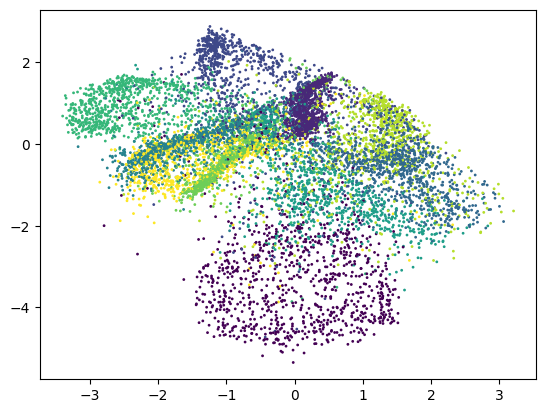

In [5]:
from matplotlib import pyplot as plt
import torch

allfeatures = torch.tensor(allfeatures)
allclasses  = torch.tensor(allclasses)

plt.scatter(allfeatures[:, 0], allfeatures[:, 1], c=allclasses, s=1)


## (Optional) polish the latent scatter & save
### Make the 2D latent plot clearer (no logic changes)

We’ll add:
- Axis labels (`z[0]`, `z[1]`)
- A title
- A colorbar with ticks 0–9
- `tight_layout()` so labels don’t get cut
- Optional `savefig(...)` to keep the notebook small and reuse the image

This step is **cosmetic only** and stays faithful to the data you computed (`μ` as features).


/tmp/ipykernel_14/468553770.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  allfeatures = torch.tensor(allfeatures)
/tmp/ipykernel_14/468553770.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  allclasses  = torch.tensor(allclasses)


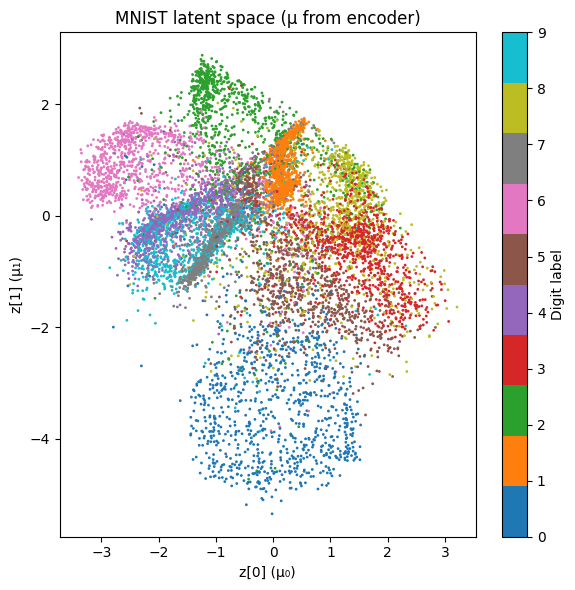

In [6]:
import matplotlib.pyplot as plt
import torch

# if already tensors from previous step, this is a no-op; just ensuring
allfeatures = torch.tensor(allfeatures)
allclasses  = torch.tensor(allclasses)

plt.figure(figsize=(6, 6))
sc = plt.scatter(allfeatures[:, 0], allfeatures[:, 1], c=allclasses, s=1, cmap="tab10")
cbar = plt.colorbar(sc, ticks=range(10))
cbar.set_label("Digit label")
plt.xlabel("z[0] (μ₀)")
plt.ylabel("z[1] (μ₁)")
plt.title("MNIST latent space (μ from encoder)")
plt.tight_layout()

# Optional: save instead of embedding huge outputs into the notebook
# plt.savefig("images/latent_mu_scatter.png", dpi=140)
plt.show()


### What do we mean by “reparameterized”?

**Idea (one-liner):**  
Instead of “sampling $z$ directly from a distribution that depends on parameters,” we **rewrite** the sample as a **deterministic function of the parameters and external noise** that does *not* depend on the parameters.

**Generic form**
$$
\varepsilon \sim p(\varepsilon)\quad\text{(fixed, parameter-free noise)}, \qquad
z \;=\; g_\theta(\varepsilon)
$$
Now $z$ is a smooth function of $\theta$, so gradients can flow through $g_\theta$ by backprop.

**Example: Normal (diagonal)**
$$
\varepsilon \sim \mathcal{N}(0, I), \qquad
z \;=\; \mu_\theta \;+\; \sigma_\theta \odot \varepsilon
$$
Here, randomness lives in $\varepsilon$; the map $(\mu_\theta,\sigma_\theta,\varepsilon)\mapsto z$ is differentiable.

**Why it helps**
- **Enables backprop:** the expected loss $\mathbb{E}[\ell(z)]$ becomes differentiable w.r.t. $\theta$.
- **Lower-variance gradients:** pathwise (reparameterized) gradients are typically much less noisy than score-function (REINFORCE) estimators.
- **Autodiff-friendly:** frameworks can compute $\nabla_\theta \ell(g_\theta(\varepsilon))$ automatically.

**In PyTorch**
```python
dist = torch.distributions.Normal(mu, std)
z = dist.rsample()  # reparameterized sample: z = mu + std * eps
# (vs. dist.sample() which is not reparameterized and breaks the grad path)
```

---------
### “How can the noise not depend on the parameters?”

When we say the **external noise** doesn’t depend on the parameters, we mean its **distribution** is *fixed* (parameter-free).  
In the reparameterization trick we pick a base noise
- e.g., $\,\varepsilon \sim \mathcal N(0, I)$ or $\,\varepsilon \sim \mathrm{Uniform}(0,1)$,
whose law **does not involve** $\theta$ (the network’s weights).

We then make the *sample we actually need* by a **deterministic transform** that *does* use the parameters:
$$
z \;=\; g_\theta(\varepsilon).
$$
For a diagonal Gaussian, this is the familiar
$$
\varepsilon \sim \mathcal N(0, I), \qquad 
z \;=\; \mu_\theta \;+\; \sigma_\theta \odot \varepsilon.
$$

- **$\varepsilon$** is random but **parameter-free** (its distribution doesn’t change when $\theta$ changes).
- **$z$** *does* depend on $\theta$ (through $\mu_\theta,\sigma_\theta$) and on the draw of $\varepsilon$.

Because $z$ is a **smooth function** of $(\mu_\theta,\sigma_\theta)$ and the fixed-law noise $\varepsilon$, we can backpropagate:
$$
\nabla_\theta\,\mathbb E_{\varepsilon}[\ell(g_\theta(\varepsilon))]
\;=\;
\mathbb E_{\varepsilon}\!\left[\frac{\partial \ell}{\partial z}\frac{\partial g_\theta(\varepsilon)}{\partial \theta}\right].
$$

This separation is the whole point:
- the **randomness** is isolated in a parameter-free source $\varepsilon$,
- the **parameter dependence** is in a differentiable map $g_\theta$,
- so gradients flow through $g_\theta$ with **low variance** (pathwise derivative).

---

#### Tiny PyTorch sanity check
```python
import torch
B, d = 4, 2
mu  = torch.randn(B, d, requires_grad=True)
logvar = torch.randn(B, d, requires_grad=True)
std = torch.exp(0.5 * logvar)

eps = torch.randn_like(std)           # base noise ~ N(0,1), parameter-free
print("eps.requires_grad:", eps.requires_grad)  # False

z = mu + std * eps                    # z depends on mu, std (→ parameters)
loss = (z**2).sum()
loss.backward()

print("mu.grad is not None:", mu.grad is not None)         # True (grad flows)
print("logvar.grad is not None:", logvar.grad is not None) # True



### Why use `rsample()` (not `sample()`)

- **Goal:** keep gradients flowing through the random latent $z$ so we can train with backprop.
- **`rsample()` = reparameterized sample:** implements $z = \mu + \sigma \odot \varepsilon$ with $\varepsilon \sim \mathcal{N}(0, I)$, which is **differentiable** w.r.t. $\mu,\sigma$.
- **`sample()` (non-reparameterized):** breaks the gradient path; autograd can’t update $\mu,\sigma$ through $z$.
- **Lower-variance grads:** pathwise (reparameterized) gradients are typically much **less noisy** than score-function (REINFORCE) estimators.
- **PyTorch usage:**
  ```python
  dist = torch.distributions.Normal(mu, std)
  z = dist.rsample()  # differentiable w.r.t. mu, std


## ex1 vs ex2 — What changed?

| Aspect | **ex1** (Deterministic AutoEncoder) | **ex2** (VAE-style AutoEncoder) |
|---|---|---|
| Encoder output | Single latent vector `z ∈ ℝ^d` | Two **heads**: mean `μ(x) ∈ ℝ^d` and std `σ(x) ∈ ℝ^d` (via `softplus`) |
| Bottleneck type | **Deterministic** | **Stochastic** (sample `z` from `𝒩(μ, σ)`) |
| Sampling step | None (just use `z = encode(x)`) | **Reparameterization trick**: `z = μ + σ ⊙ ε`, with `ε ~ 𝒩(0, I)` |
| Forward pass | `x̂ = decode(encode(x))` | `μ, σ = encode(x); z = rsample(μ, σ); x̂ = decode(z)` |
| Loss used | **Reconstruction only** (L1) | **Reconstruction only** (L1) — *no KL term in this notebook* |
| Latent used for plots | `z` | **`μ`** (stable point estimate); `σ` expresses uncertainty |
| Generative behavior | Limited (no inherent sampling) | Can **sample** different `z` for the same `x`; easy to extend to full VAE |
| Uncertainty | Not modeled | **Modeled** via `σ(x)` |
| Path to true VAE | Add nothing (already deterministic) | Add **KL term** to match `q(z|x)` to `𝒩(0, I)`; optionally weight with β |

### Minimal code diff (illustrative)

**ex1 (deterministic)**
```python
# encode -> z (deterministic)
z = encoder(flatten(x))              # [B, d]
x_hat = decode(z)                    # [B, 1, 28, 28]
loss = L1(x, x_hat)
```

**ex2 (VAE-style)**
``` python
# two heads + reparameterization
mu, std = encode(x)                  # [B, d], [B, d]
z = torch.distributions.Normal(mu, std).rsample()
x_hat = decode(z)
loss = L1(x, x_hat)                  # (no KL in this notebook)
# to make it a true VAE, add: loss += β * KL(N(mu, std) || N(0, I))

```

--------

**when to use which?**
* **ex1**: simplest reconstruction model; good for quick AEs and 2D latent visualization without stochasticity.

* **ex2**: prepares you for generative modeling; supports sampling & uncertainty. Add a KL term to become a proper VAE with a smooth, well-behaved latent space.